In [ ]:
import os
import json
import pickle
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
mnist = tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test) = mnist.load_data()

#normalizing
x_train = x_train/255
x_test = x_test/255

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
data_folder = r'/content/drive/MyDrive/DLS/hw4/'

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test) = mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
#normalizing -1 to 1 scale
x_train = (x_train-127.5)/127.5
x_test = (x_test-127.5)/127.5


#reshape to 784
x_train = x_train.reshape(x_train.shape[0],784)
x_test = x_test.reshape(x_test.shape[0],784)

# One-hot encode labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [ ]:
x_train.shape, y_train.shape

((60000, 784), (60000, 10))

In [301]:
def build_generator(latent_dim):
    input_noise = tf.keras.layers.Input(shape=(latent_dim,))
    input_label = tf.keras.layers.Input(shape=(10,))
    merged = tf.keras.layers.Concatenate(axis=1)([input_noise, input_label])

    x = tf.keras.layers.Dense(200, activation='relu')(merged)
    x = tf.keras.layers.Dense(400, activation='relu')(x)
    output = tf.keras.layers.Dense(784, activation='tanh')(x)

    model = tf.keras.Model(inputs=[input_noise, input_label], outputs=output)
    return model

def build_discriminator():
    input_img = tf.keras.layers.Input(shape=(784,))
    input_label = tf.keras.layers.Input(shape=(10,))
    merged = tf.keras.layers.Concatenate(axis=1)([input_img, input_label])
    x = tf.keras.layers.Dense(400, activation='relu')(merged)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(200, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(100, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.15)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[input_img, input_label], outputs=output)
    return model


In [508]:
latent_dim = 100
generator = build_generator(latent_dim)
discriminator = build_discriminator()

In [509]:
initial_learning_rate = 0.0005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps= 2000,
    decay_rate=0.95,
    staircase=False)

initial_learning_rate1 = 0.0005
lr_schedule_gen = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate1,
    decay_steps= 2000,
    decay_rate=0.95,
    staircase=False)


discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss='binary_crossentropy',metrics=['accuracy'])
discriminator.trainable = False  # Only train generator in the combined model

gan_input_noise = tf.keras.layers.Input(shape=(latent_dim,))
gan_input_label = tf.keras.layers.Input(shape=(10,))
generated_image = generator([gan_input_noise, gan_input_label])
gan_output = discriminator([generated_image, gan_input_label])

gan = tf.keras.Model(inputs=[gan_input_noise, gan_input_label], outputs=gan_output)
gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule_gen), loss='binary_crossentropy',metrics=['accuracy'])

generator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule_gen))

In [510]:
@tf.function
def train_step(gan,generator,discriminator,x_batch,y_batch,latent_dim):

    curr_size = x_batch.shape[0]

    noise = tf.random.normal(shape=(curr_size, latent_dim))
    sampled_labels = np.random.randint(0, 10, curr_size)
    sampled_labels = tf.keras.utils.to_categorical(sampled_labels, 10)

    gen_imgs = generator([noise, sampled_labels])

    discriminator.trainable = True
    # Train Discriminator
    with tf.GradientTape() as disc_tape:
        real_output = discriminator([x_batch, y_batch], training=True)
        d_loss_real = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output))
        fake_output = discriminator([gen_imgs, sampled_labels], training=True)
        d_loss_fake = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output))
        d_loss = (d_loss_real + d_loss_fake)/2

    gradients_of_discriminator = disc_tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator.optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    d_real_acc = tf.reduce_mean(tf.keras.metrics.binary_accuracy(tf.ones_like(real_output),real_output))
    d_fake_acc = tf.reduce_mean(tf.keras.metrics.binary_accuracy(tf.ones_like(fake_output),fake_output))

    discriminator.trainable = False
    # Train Generator
    for i in range(1):
        noise = tf.random.normal(shape=(curr_size, latent_dim))
        sampled_labels = np.random.randint(0, 10, curr_size)
        sampled_labels = tf.keras.utils.to_categorical(sampled_labels, 10)

        # Train Generator
        with tf.GradientTape() as gen_tape:
            fake_output = gan([noise, sampled_labels], training=True)
            g_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output))

        gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
        generator.optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))


    return d_loss_real, d_loss_fake, g_loss, d_real_acc, d_fake_acc #taking 1 minus because it was calculated with zeros during train on batch


In [511]:
epochs=300
batch_size=250
latent_dim=100

dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)

disc_loss_real,disc_loss_fake, gen_loss = [],[],[]
real_accs, fake_accs = [],[]

for epoch in range(epochs):
    batch_d_loss_r,batch_d_loss_f,batch_g_loss = [],[],[]
    batch_real_acc = []
    batch_fake_acc = []
    for x_batch, y_batch in dataset:
        d_loss_real, d_loss_fake, g_loss,d_real_acc,d_fake_acc = train_step(gan,generator, discriminator,x_batch, y_batch, latent_dim)

        batch_d_loss_r.append(d_loss_real)
        batch_d_loss_f.append(d_loss_fake)

        batch_g_loss.append(g_loss)
        batch_real_acc.append(d_real_acc)
        batch_fake_acc.append(d_fake_acc)


    #epoch loss and accuracy
    e_real_acc = np.mean(batch_real_acc)
    e_fake_acc = np.mean(batch_fake_acc)

    real_accs.append(e_real_acc)
    fake_accs.append(e_fake_acc)

    #epoch loss
    e_d_loss_r = np.mean(batch_d_loss_r)
    e_d_loss_f = np.mean(batch_d_loss_f)

    e_g_loss = np.mean(batch_g_loss)
    disc_loss_real.append(e_d_loss_r)
    disc_loss_fake.append(e_d_loss_f)

    gen_loss.append(e_g_loss)

    # Print the progress
    print(f'''Epoch:{epoch} ==> D loss Real: {e_d_loss_r} D loss Fake: {e_d_loss_f} G loss: {e_g_loss} Real acc: {e_real_acc} Fake Acc: {e_fake_acc}''')

Epoch:0 ==> D loss Real: 0.02785014547407627 D loss Fake: 0.10074160248041153 G loss: 6.425940036773682 Real acc: 0.9898166656494141 Fake Acc: 0.05051666125655174
Epoch:1 ==> D loss Real: 0.08731041103601456 D loss Fake: 0.09740450978279114 G loss: 7.013375759124756 Real acc: 0.969249963760376 Fake Acc: 0.03349999710917473
Epoch:2 ==> D loss Real: 0.14702005684375763 D loss Fake: 0.09655788540840149 G loss: 4.97550630569458 Real acc: 0.9416666626930237 Fake Acc: 0.028750000521540642
Epoch:3 ==> D loss Real: 0.18798154592514038 D loss Fake: 0.10889235883951187 G loss: 3.765970468521118 Real acc: 0.9191833138465881 Fake Acc: 0.02733333595097065
Epoch:4 ==> D loss Real: 0.23185071349143982 D loss Fake: 0.16610589623451233 G loss: 3.255882740020752 Real acc: 0.8923333287239075 Fake Acc: 0.0429999977350235
Epoch:5 ==> D loss Real: 0.24708525836467743 D loss Fake: 0.1873258501291275 G loss: 3.115790367126465 Real acc: 0.8930833339691162 Fake Acc: 0.060750000178813934
Epoch:6 ==> D loss Real:

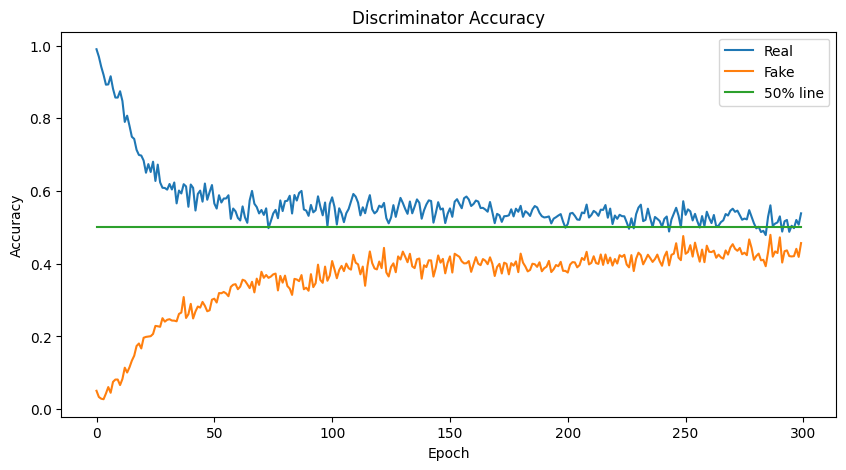

In [512]:
plt.figure(figsize=(10,5))
plt.plot(real_accs,label='Real')
plt.plot(fake_accs,label='Fake')
plt.plot([0.5]*len(real_accs),label='50% line')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Discriminator Accuracy')
plt.show()

In [639]:
latent_dim = 100
noise = np.random.normal(0, 1, (100, latent_dim))
#build 10 examples for each class
sample_labels = []
for i in range(10):
    sample_labels.extend([i]*10)

sample_labels = tf.keras.utils.to_categorical(np.array(sample_labels),10)


In [640]:
tf.reduce_mean(tf.keras.metrics.binary_accuracy(tf.ones((1000)),gan.predict([noise,sample_labels],batch_size=100)))

1/1 [==============================] - 0s 21ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.41>

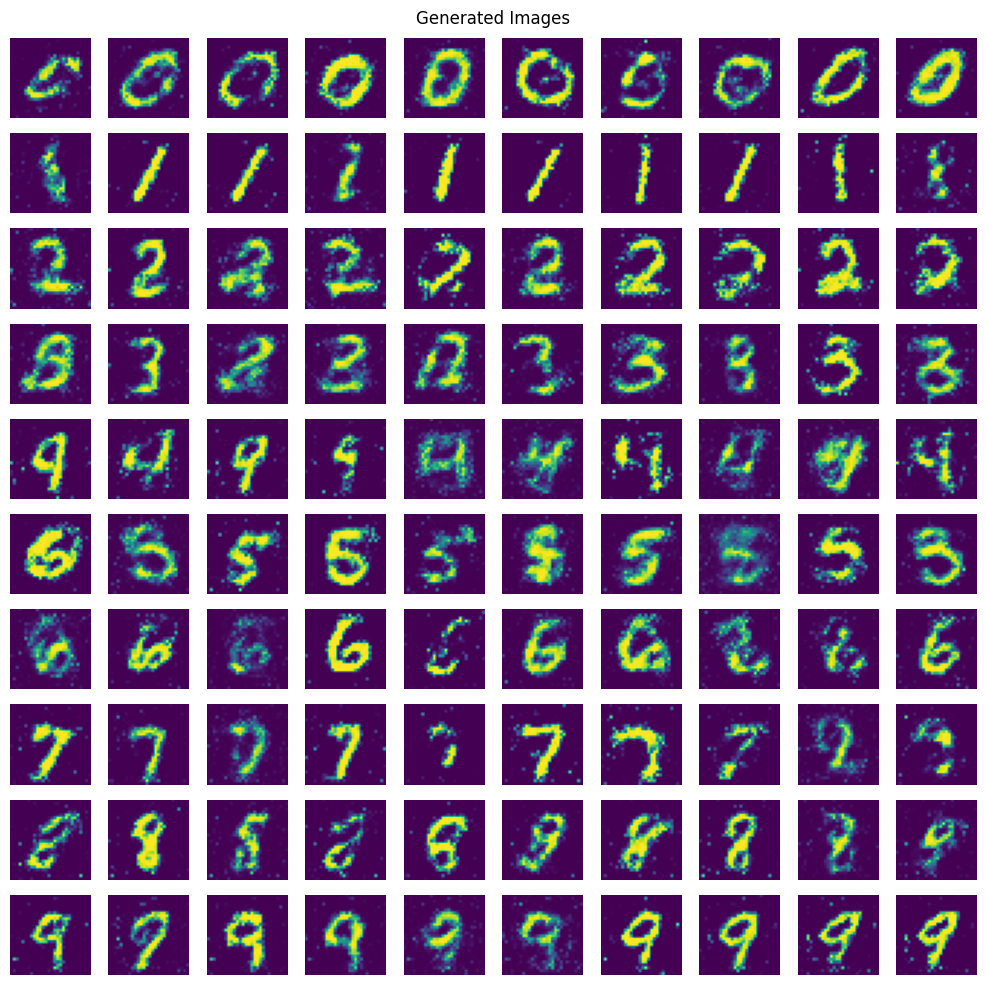

In [641]:

generated_images = generator.predict([noise, sample_labels],verbose=0,batch_size=100)
#rescale to 0 to 1
generated_images = (generated_images+1)/2
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for row in range(10):
    for col in range(10):
        ax[row, col].imshow(generated_images[(row*10)+col, :].reshape((28, 28)))
        ax[row, col].axis("off")
# plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle('Generated Images')
plt.tight_layout()
plt.show()

### Discussion:
- Although, I achieved kind of nash equilibrium, around ~50% of the images look good and other 50% have some kind of noise like very less thickness of stroke,or breaks in between.